In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import optimizers, backend, losses, Sequential
from numpy.random import seed
from tensorflow import set_random_seed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Data extraction

We already did the high features extraction on another ipynb file and then saved them on npz files. We download here the npz files.

In [2]:
## Download npz files
#####################
## Train set
with np.load('data_train.npz',allow_pickle=False) as train_npz:
    data = dict(train_npz.items())
    X_train = data['features'].astype(np.float32)
    y_train = data['targets']
    H_train = data['highfeat'].astype(np.float32) ## The high-level features
    filenames_train = data['filenames']
    names = data['names']
## Valid set
with np.load('data_valid.npz',allow_pickle=False) as valid_npz:
    data = dict(valid_npz.items())
    X_valid = data['features'].astype(np.float32)
    y_valid = data['targets']
    H_valid = data['highfeat'].astype(np.float32)
    filenames_valid = data['filenames']
## Test set
with np.load('data_test.npz',allow_pickle=False) as test_npz:
    data = dict(test_npz.items())
    X_test = data['features'].astype(np.float32)
    y_test = data['targets']
    H_test = data['highfeat'].astype(np.float32)
    filenames_test = data['filenames']
    
## Print different shapes
#########################
print('The shapes of the data : ')
print(' ')
print('X_train : {} y_train : {} H_train : {} names : {}'.format(X_train.shape,
                                        y_train.shape,H_train.shape,names.shape))
print('X_valid : {} y_valid : {} H_valid : {}'.format(X_valid.shape,y_valid.shape,
                                                      H_valid.shape))
print('X_test : {} y_test : {} H_test : {}'.format(X_test.shape,y_test.shape,
                                                   H_test.shape))

The shapes of the data : 
 
X_train : (280, 32, 32, 3) y_train : (280,) H_train : (280, 1280) names : (6,)
X_valid : (139, 32, 32, 3) y_valid : (139,) H_valid : (139, 1280)
X_test : (50, 32, 32, 3) y_test : (50,) H_test : (50, 1280)


Since we will use only cross-validation techniques to tune our different hyperparameters and Keras API for the deep learning models which includes validations set in the training set, it is more convenient for us to merge the training and validation data together.

In [3]:
## Merge training/validation set
################################
X_train = np.concatenate((X_train,X_valid))
y_train = np.concatenate((y_train,y_valid))
H_train = np.concatenate((H_train,H_valid))
filenames_train=np.concatenate((filenames_train,filenames_valid))

# Data exploration

## Plot a few images

We plot some images from each category.

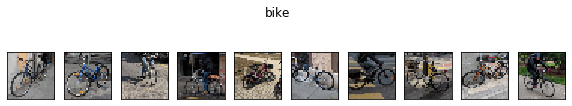

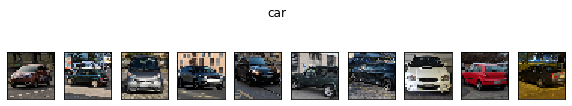

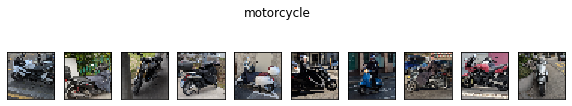

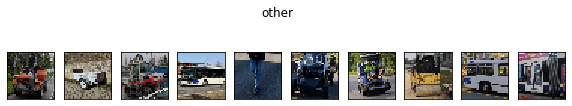

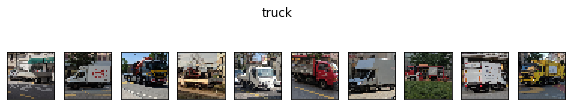

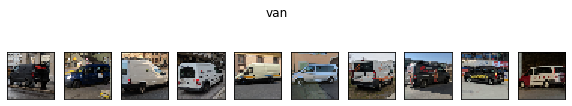

In [4]:
## Define a function that plot images from the same category
############################################################
def plot_images(number_images,category):
    ## Get category's name
    category_name = names[category]
    ## Filter
    category_indices = (y_train==category)
    category_images = X_train[category_indices]
    ## Choose random images
    np.random.seed(category)
    indices = np.arange(len(category_images))
    np.random.shuffle(indices)
    indices = indices[:number_images]
    images_to_draw = category_images[indices]
    
    ## Plot the images
    fig, axes = plt.subplots(1,number_images,figsize=(10,2))
    plt.suptitle(category_name)
    for i,ax in enumerate(axes.flatten()):
        ax.imshow(images_to_draw[i])
        ax.get_xaxis().set_visible(False) # disable x-axis
        ax.get_yaxis().set_visible(False) # disable y-axis
    plt.show()
    
## Plot the images
##################
for i in range(6):
    plot_images(number_images=10,category=i)

## PCA components

We start by making a scree plot, meaning in this case that we plot the cumulative sum of the proportion of variance explained (in terms of the number of principal components).

In [5]:
## Rescale the data
scaler = StandardScaler()
H_train_rescaled = scaler.fit_transform(H_train)
## Create the PCA transformer
pca = PCA(n_components=None) # no restriction on the number of components
## Apply PCA to rescaled data
pca.fit(H_train_rescaled)
## Get the proportion of variance explained
pve = pca.explained_variance_ratio_
## Print the shape
print('pve.shape = ',pve.shape)

pve.shape =  (419,)


We obtain a vector with $419$ entries, each of them corresponds to a principal component and the associated value is what we call the proportion of variance explained. Note that although we have 1280 features, the number of principal components is given by the number of point ($=419$) since the dimension of the space generated by all the data is at most $419$ (all other projections will be zero).

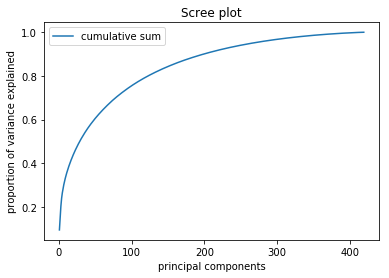

In [6]:
# Create scree plot
###################
xcor = np.arange(1,len(pve)+1) ## 1,2,...,n component
plt.plot(xcor, np.cumsum(pve),label='cumulative sum')
plt.xlabel('principal components')
plt.ylabel('proportion of variance explained')
plt.title('Scree plot')
plt.legend()
plt.show()

In [7]:
## A small function to get the number of component to explain x% of the variance
################################################################################
def get_number_component(x): 
    if x<=100:
        i=0
        while (np.cumsum(pve)[i]*100) < x:
            i+=1
        return(i+1)
    else:
        return get_number_component(100)

## Put the results in a DataFrame form
######################################
percentages = np.arange(10,101,10)
components = [get_number_component(x) for x in percentages]
pd.DataFrame({'Percentage':percentages,
'Principal components':components}).set_index('Percentage')

,Principal components
Percentage,
10,2
20,3
30,7
40,16
50,29
60,49
70,79
80,123
90,199


We see that if we want to keep a good amount of informations, we can restrict to $200$ principal components, which encodes $90$% of the variance explained. This reduction of the number of features might have some computational advantages.

In [8]:
## Get the projection on the first two components
#################################################
## The high level features
H_2d = pca.transform(H_train_rescaled)[:,0:2]
## The images features
X_train_rescaled = scaler.fit_transform(X_train.reshape(-1,32*32*3))
X_2d = pca.fit_transform(X_train_rescaled)[:,0:2]

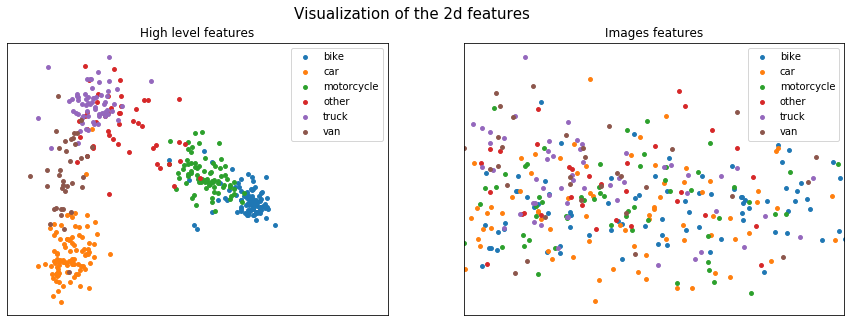

In [9]:
## Scatter plot of the first two components
###########################################
fig,ax = plt.subplots(1,2,figsize=(15,5))
## The high level features
for i in range(6):
    idx = (y_train==i)
    name = names[i]
    ax[0].scatter(H_2d[idx,0],H_2d[idx,1],s=15,label=name)
    ax[0].legend(loc='upper right')
ax[0].set_xlim(-20,35) 
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('High level features')
## The image features
for i in range(6):
    idx = (y_train==i)
    name = names[i]
    ax[1].scatter(X_2d[idx,0],X_2d[idx,1],s=15,label=name)
    ax[1].legend(loc='upper right')
ax[1].set_xlim(-20,35) 
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Images features')
plt.suptitle('Visualization of the 2d features',fontsize=15)
plt.show()

We remark the impressive difference between the two plots. In the second one, the categories seem to be equidistributed in the plan so it is very difficult to predict something from the first two components. On the other hand, the high level features distinguish very well the different nature of the points. Moreover, it also clusters the data into three groups, which seem to depend on the size of the vehicules.

# Visual search with $k$-NN

## Fit and tune a $k$-NN classifier

We will tune a $k$-NN classifier by looking at the accuracy for several values of the number of neighbors $k$, the way we assign weight to points and the metric ($p=1,2$).

In [10]:
## The grid of parameters
grid = ParameterGrid({
    'knn__n_neighbors': np.arange(1,20), ## The number of neighbors
    'knn__weights': ['uniform', 'distance'], ## The weight of the neighbors
    'knn__p': [1,2] ## The metric 
})
## Create the k-NN object
knn = KNeighborsClassifier()
## Create the pipeline
pipe_knn = Pipeline([
    ('scaler',StandardScaler()),
    ('knn',knn)
])

## Grid search
##############
## Save the results
gs_results = []
for param_dict in grid:
    ## Assign the current parameters
    pipe_knn.set_params(**param_dict)
    ## Fit the k-NN model
    pipe_knn.fit(H_train,y_train)
    ## Compute accuracy
    param_dict['accuracy'] = pipe_knn.score(H_test,y_test)
    ## Save the results
    gs_results.append(param_dict)

## Print the results in a DataFrame
###################################
result_df = pd.DataFrame(gs_results).sort_values('accuracy',ascending=False)
result_df.head(7)

,accuracy,knn__n_neighbors,knn__p,knn__weights
36,0.98,10,1,uniform
8,0.98,3,1,uniform
57,0.98,15,1,distance
49,0.98,13,1,distance
48,0.98,13,1,uniform
45,0.98,12,1,distance
9,0.98,3,1,distance


We see that after a grid search, we obtain an accuracy of $98$%. We also tested without rescaling the data but got a lower result. For the rest of this exercise, we set the number of neighbors to $3$ with the uniform distance and the $L^1$ norm.

## Plot the 10 nearest neighbors

In [11]:
## Set k=3, weight = 'uniform' and p=1
pipe_knn.set_params(knn__n_neighbors=3,knn__weights='uniform',knn__p=1)
## Fit on the training set
pipe_knn.fit(H_train,y_train)
## Compute and print accuracy
accuracy_knn = pipe_knn.score(H_test,y_test)
print('k-NN test accuracy : ',accuracy_knn)

k-NN test accuracy :  0.98


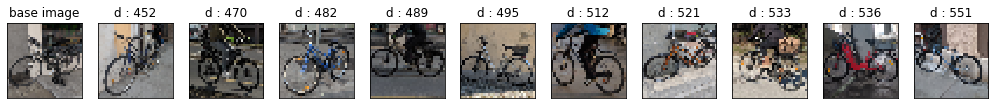

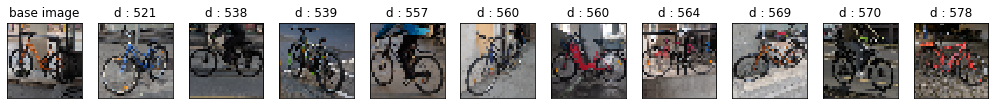

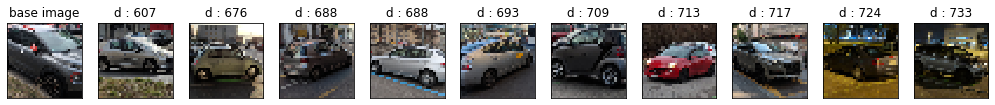

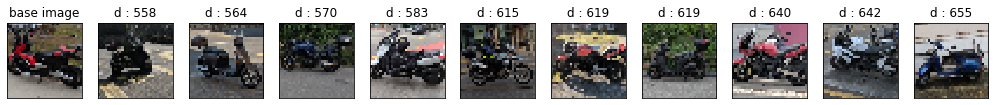

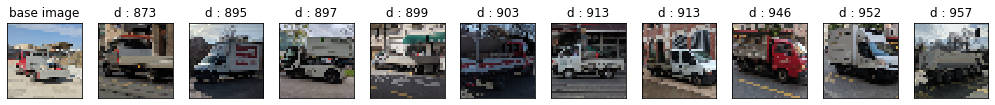

In [12]:
## The function that plots the 10 nearest neighbors
###################################################
def plot_k_nn(img_index,k): ## The image is in the high feature form
    
    ## Compute the k nearest images and their distances
    ###################################################
    base_img = X_test[img_index] # The image corresponding to the index
    scaler = StandardScaler()
    scaler.fit(H_train)
    H_test_rescaled = scaler.transform(H_test)
    base_img_high = H_test_rescaled[img_index] # The high level features with this index
    nn = pipe_knn.named_steps['knn'].kneighbors(X=base_img_high.reshape((-1,1280)), 
                        n_neighbors=k) # Return tuple of (distance/index)
    
    ## print images
    ###############
    fig,axes = plt.subplots(1,k+1,figsize=(k+4,3))
    ## the base image
    axes[0].imshow(base_img)
    axes[0].set_title('base image')
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)    
    ## Plot the k others
    for i in range(k):
        idx = nn[1][0][i]
        d = nn[0][0][i]
        img = X_train[idx]
        axes[i+1].imshow(img)
        axes[i+1].set_title('d : {:.0f}'.format(d))
        axes[i+1].get_xaxis().set_visible(False)
        axes[i+1].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

## Plot some images
###################
for i in np.arange(0,50,10):
    plot_k_nn(i,10)

# Simple decision trees

## The $k$-NN baseline vs Decision tree

In [13]:
# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
# Fit it
dummy.fit(None,y_train)
# Compute test accuracy
accuracy_baseline = dummy.score(None, y_test)
print('Baseline accuracy: {}'.format(accuracy_baseline))

Baseline accuracy: 0.24


We see that if we take the most frequent value as a baseline model, we get an accuracy of $24$%. We can also compute it in a very elementary way : Let's take the most frequent value :

In [14]:
## The most frequent value in the training set
freq = (pd.value_counts(y_train)).idxmax() 
## Its occurence in the test set
test_occ = pd.value_counts(y_test)[freq]
## The accuracy 
accuracy_baseline = test_occ/len(y_test)
print('Baseline accuracy:', accuracy_baseline)

Baseline accuracy: 0.24


## Simple decision tree with depth 3

Let's see if we can do better with a decision tree of depth 3.

In [15]:
## Create decision tree
dt = DecisionTreeClassifier(
    criterion='entropy', max_depth=3, random_state=0)
## Create the pipeline
pipe_tree = Pipeline([
    ('scaler',StandardScaler()),
    ('dt',dt)
])
## Fit decision tree
pipe_tree.fit(H_train,y_train)
## Print the accuracy
dt
print('Decision tree accuracy: ',pipe_tree.score(H_test,y_test))

Decision tree accuracy:  0.78


Here we choosed the `cross-entropy` criterion to measure impurity at each leaf. We also tried `gini` but got a lower result of $68$%. We indeed obtain a better score that the baseline model. This is not very surprising because the model that predicts the most frequent value correpnds to a decision tree with depth $0$.

## Plot the tree with `graphviz`

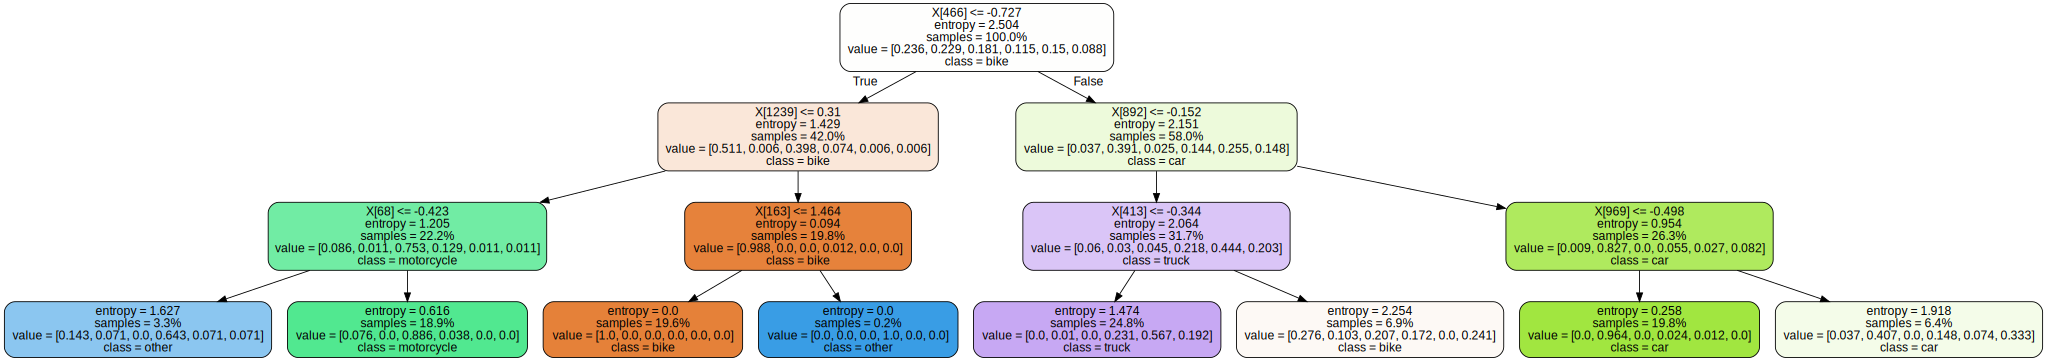

In [16]:
# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    #feature_names=features.columns, 
    class_names=names,
    filled=True, rounded=True, proportion=True   
)
# Display decision tree
graphviz.Source(dot_data)

## Decision tree with PCA

Let's add a PCA reduction in our pipeline object and tune the model using grid search on the number of component and the max depth.

In [17]:
## Create the new pipeline with PCA
pipe_tree = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(random_state=0)),  ## add the pca
    ('dt',dt)
])
##  Create the grid for the number of components, the max depth and the impurity criterion
grid_tree = ParameterGrid({
    'pca__n_components': np.arange(2,200,10),
    'dt__max_depth': np.arange(1,11),
    'dt__criterion':['gini','entropy']
})
## Store the accuracy
gs_results = []
## Grid search
for param_dict in grid_tree:
    pipe_tree.set_params(**param_dict)
    pipe_tree.fit(H_train,y_train)
    param_dict['test accuracy'] = pipe_tree.score(H_test,y_test)
    param_dict['train accuracy'] = pipe_tree.score(H_train,y_train)
    gs_results.append(param_dict)
    
## Show the results in a DataFrame 
##################################
df = pd.DataFrame(gs_results).sort_values('test accuracy',ascending=False)
df.head()

,dt__criterion,dt__max_depth,pca__n_components,test accuracy,train accuracy
121,gini,7,12,0.9,0.980907
70,gini,4,102,0.9,0.935561
63,gini,4,32,0.9,0.933174
62,gini,4,22,0.9,0.933174
65,gini,4,52,0.9,0.933174


We obtain a stronger result, namely we pass from $78$% to $90$% when we reduce the number of principal components to $22$ and set the max depth to $4$! Observe that this time the better score is achieved with the `gini` criterion. We also point out that the model clearly overfeats when the max depth becomes too large as shows the following plot.

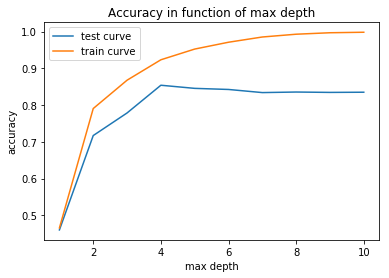

In [18]:
## Plot the test/train accuracy in function of max depth/pca
############################################################
## The two grouped frames
df_depth = df.groupby('dt__max_depth').mean()
## The plot
## Function of max depth
plt.plot(df_depth.index.values,df_depth['test accuracy'].values,label='test curve')
plt.plot(df_depth.index.values,df_depth['train accuracy'].values,label='train curve')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Accuracy in function of max depth')
plt.legend()
plt.show()

It seems that setting the max depth to $4$ is good compromise to avoid overfitting. In this case, we obtain an accuracy of almost $90$%, which is much better than without applying PCA reduction. 

In [19]:
## Store the accuracy tree
accuracy_tree = df.iloc[3,3]

# Logistic regression

## Evaluate the logistic regression

In [20]:
## Create the pipeline
pipe_logreg = Pipeline([
    ('scaler',StandardScaler()),
    ('logreg',LogisticRegression(solver='liblinear',multi_class='auto'))
])
## Fit the logistic regression
pipe_logreg.fit(H_train,y_train)
## Evaluate the accuracy
accuracy_logreg = pipe_logreg.score(H_test,y_test)
print('Logistic regression accuracy : {:.2f}'.format(accuracy_logreg))

Logistic regression accuracy : 0.96


## Grid search with cross-validation

In [21]:
## Create the grid for the regularization constant
grid = {
    'logreg__C': np.logspace(-4, 4, num=10)
}
## Create the gdCV object
grid_cv = GridSearchCV(pipe_logreg, grid, cv=5, return_train_score=True,iid=False)
## Fit the cross validation
grid_cv.fit(H_train,y_train)
## Interesting columns
cols = ['param_logreg__C','mean_test_score','std_test_score','mean_train_score',
       'std_train_score']
pd.DataFrame(grid_cv.cv_results_)[cols].sort_values('mean_test_score',
                                                    ascending=False).head()

,param_logreg__C,mean_test_score,std_test_score,mean_train_score,std_train_score
8,1291.55,0.921460,0.019659,1.000000,0.000000
9,10000,0.921292,0.011613,1.000000,0.000000
3,0.0464159,0.914033,0.014251,1.000000,0.000000
4,0.359381,0.909327,0.019193,1.000000,0.000000
2,0.00599484,0.909211,0.014752,0.995222,0.001475


Observe that the mean test score is the mean accuracy computed with respect to several validation sets inside the training set. If we evaluate the best estimator on our test set, we get the same accuracy as before ($96$%), so it seems that the tuninig process doesn't improve the test accuracy.

## Predict probability

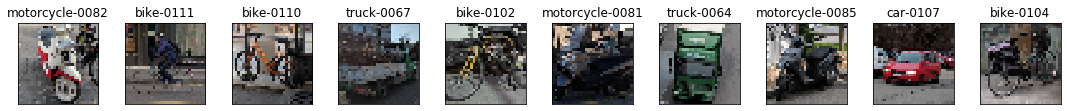

In [22]:
## Choose ten random images
np.random.seed(0)
idx = np.arange(len(y_test))
np.random.shuffle(idx)
images_to_predict = H_test[idx[0:10]]
## Put the index name in a more correct form
files = pd.Series(filenames_test[idx[0:10]])
files = files.str.replace('.png','')
files = files.str.replace('\w+/','')
files = files.values    
## Plot the 10 images
fig,ax = plt.subplots(1,10,figsize=(15,2))
for i in range(10):
    ax[i].imshow(X_test[idx[i]])
    ax[i].set_title(files[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [23]:
## Compute the associated probability
proba = grid_cv.predict_proba(images_to_predict)
## Create the DataFrame
proba_df = pd.DataFrame(proba,index=files,columns=names)
proba_df

,bike,car,motorcycle,other,truck,van
motorcycle-0082,8.315387e-03,1.249987e-06,9.910423e-01,1.968833e-06,6.387208e-04,3.606582e-07
bike-0111,9.992251e-01,7.037239e-05,2.739724e-05,2.805607e-05,6.486509e-04,3.823159e-07
bike-0110,9.998847e-01,3.037146e-06,4.817706e-07,3.882172e-05,1.868141e-05,5.426974e-05
truck-0067,1.675590e-06,3.040466e-07,7.036399e-09,3.191741e-01,6.773854e-01,3.438515e-03
bike-0102,9.977536e-01,1.028536e-05,2.228391e-03,1.969628e-07,1.350466e-06,6.200005e-06
motorcycle-0081,1.244723e-07,4.817801e-05,9.996659e-01,2.823071e-04,3.471000e-06,4.659534e-08
truck-0064,2.042253e-04,2.506147e-08,1.000533e-04,8.994502e-01,1.002411e-01,4.316618e-06
motorcycle-0085,2.564051e-06,1.078398e-05,9.999437e-01,7.737336e-06,7.788167e-06,2.743583e-05
car-0107,4.982113e-06,9.176740e-01,5.791342e-06,1.009146e-03,8.130461e-02,1.449918e-06
bike-0104,9.995325e-01,7.756409e-06,3.968466e-04,2.971853e-05,2.958506e-07,3.285912e-05


Note that these probabilities are computed with the best estimator; namely with the parameters giving the highest mean test score. We can try to vary this constant and see what is the effect on the repartition of these probabilities. For this, we choose four pictures, fit the model with cross validation with $3$ values of $C$ and evaluate the model on these three pictures.

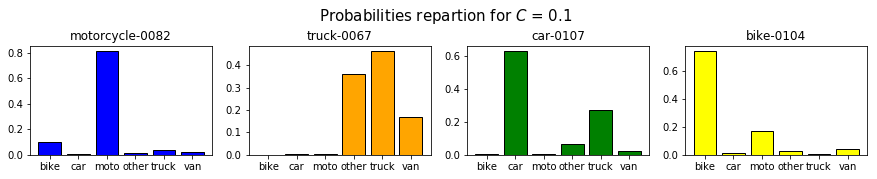

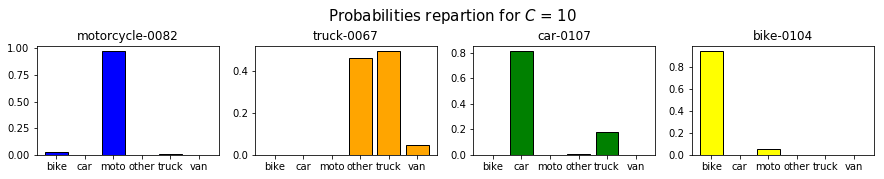

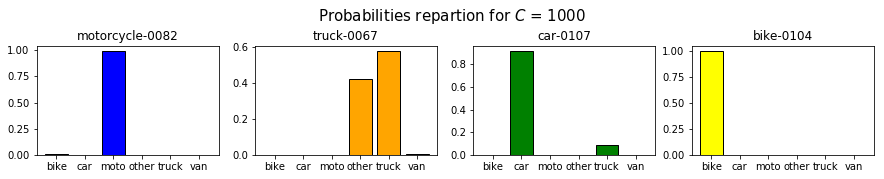

In [24]:
colors = ['blue','orange','green','yellow']
for C in [0.1,10,1000]:
    ## Fix the parameter C in the cross validation
    grid_cv.set_params(param_grid = {'logreg__C': np.array([C])})
    ## Fit the cross validation
    grid_cv.fit(H_train,y_train)
    ## Predict proba on 4 images
    names = ['bike', 'car', 'moto', 'other', 'truck', 'van']
    proba = grid_cv.predict_proba(images_to_predict[[0,3,8,9]])
    proba_df = pd.DataFrame(proba,index=files[[0,3,8,9]],columns=names)
    ## Create the bar plot
    fig, axes = plt.subplots(1,4,figsize=(15,2))
    for i in range(4):
        axes[i].bar(names,proba_df.iloc[i,:],color=colors[i],edgecolor='black')
        axes[i].set_title(proba_df.index[i])
    plt.suptitle('Probabilities repartion for $C$ = {}'.format(C),
                 fontsize=15).set_position([0.51, 1.15])
    plt.show()

We remark that in general, the higher the constant is, the more the probability is concentrated on the true value. We do not observe this behaviour on 'truck 0067' because the algorithm seems not be able to distinguish between 'truck' and 'other'.

# Nonlinear classifiers

## Random forest

In [25]:
## Create a Pipeline random forest
pipe_forest = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=22)),
    ('rf',RandomForestClassifier(max_depth=4,random_state=0))
])
## Create a grid for the number of trees
grid_forest = ParameterGrid({    
    'rf__n_estimators': np.arange(1,1500,50)  ## The number of trees
})
gs_results = []
## Grid search
for param_dict in grid_forest:
    pipe_forest.set_params(**param_dict)
    pipe_forest.fit(H_train,y_train)
    param_dict['test accuracy'] = pipe_forest.score(H_test,y_test)
    param_dict['train accuracy'] = pipe_forest.score(H_train,y_train)
    gs_results.append(param_dict)

## Create the DataFrame
#######################
grid_forest_df = pd.DataFrame(gs_results)
grid_forest_df.sort_values('test accuracy',ascending=False).head()

,rf__n_estimators,test accuracy,train accuracy
4,201,0.94,0.964200
15,751,0.92,0.961814
16,801,0.92,0.957041
28,1401,0.92,0.957041
27,1351,0.92,0.961814


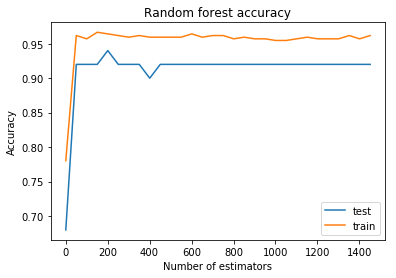

In [26]:
## Plot the train/test accuracy
###############################
plt.plot(grid_forest_df.iloc[:,0],grid_forest_df.iloc[:,1],label='test')
plt.plot(grid_forest_df.iloc[:,0],grid_forest_df.iloc[:,2],label='train')
plt.title('Random forest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Following our analysis of the simple tree case, we choosed to use $22$ principal components and a depth of $4$ for each tree. The above plot shows that increasing the number of estimators does not improve the accuracy of the model since it seems to tend asymptotically to $92$%. A correct number should be around $200$ estimators because it maximizes the test accuracy and minimizes the overfitting.

In [27]:
## Compute the test accuracy with 200 estimators
################################################
pipe_forest.set_params(rf__n_estimators=200)
pipe_forest.fit(H_train,y_train)
accuracy_forest = pipe_forest.score(H_test,y_test)
print('Random forest accuracy with 200 estimators : ',accuracy_forest)

Random forest accuracy with 200 estimators :  0.92


## Support vector machine

In [33]:
## Create the pipeline object
pipe_svm = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(random_state=0)),
    ('svm',SVC())
])
## The grid of parameters
grid_svm = ParameterGrid([{
    ## Linear kernel
    'svm__kernel':['linear'], 
    'svm__C': [0.1,1,10], ## The parameter that controls the complexity of the model
    'svm__gamma': ['auto'],
    'pca__n_components': np.arange(2,200,10),
    
},{
    ## RBF kernel
    'svm__kernel':['rbf'],
    'svm__C':[0.1,1,10],
    'pca__n_components': np.arange(2,200,10),
    'svm__gamma': ['auto',0.1,1,100,1000] ## Control the smoothness of the 
                                                     ## decision boundary
}])
gs_result = []
## Grid search
for param_dict in grid_svm:
    pipe_svm.set_params(**param_dict)
    pipe_svm.fit(H_train,y_train)
    param_dict['accuracy'] = pipe_svm.score(H_test,y_test)
    gs_result.append(param_dict)
## Create the dataframe
svm_df = pd.DataFrame(gs_result)

In [34]:
svm_df.sort_values('accuracy',ascending=False).head()

,accuracy,pca__n_components,svm__C,svm__gamma,svm__kernel
46,0.96,152,1.0,auto,linear
31,0.96,102,1.0,auto,linear
45,0.96,152,0.1,auto,linear
47,0.96,152,10.0,auto,linear
30,0.96,102,0.1,auto,linear


We see that we obtain the best results with a linear kernel and with $152$ or $102$ principal components. It seems that in this case the RBF kernel does not perform better that the linear one. In view of the scatter plot of the two principal components, which distinguish very well the different categories, we should obtain a quite good score with two components and a RBF kernel. This is indeed the case and it turns out that the maximal score with RBF is obtained with $2$ components.

In [36]:
svmrbf_df = svm_df.groupby('svm__kernel').get_group('rbf').sort_values('accuracy',
                                                    ascending=False).head()
svmrbf_df

,accuracy,pca__n_components,svm__C,svm__gamma,svm__kernel
65,0.86,2,1.0,auto,rbf
66,0.86,2,1.0,0.1,rbf
70,0.86,2,10.0,auto,rbf
71,0.86,2,10.0,0.1,rbf
61,0.82,2,0.1,0.1,rbf


Of course we need to use this time the kernel trick since the points are clearly not linearly separable in $\mathbb{R}^2$, but certainly in $\mathbb{R}^n$ with $n>2$ by applying suitable transformations on the additional coordinates. 

In [37]:
## Save the accuracy
####################
accuracy_svm_linear = svm_df.iloc[0,0]
accuracy_svm_rbf = svmrbf_df.iloc[0,0]

# Dense network

Following the recommendation of the course, we will implement our neural network of this task and the following with Keras API, since the implementation is more straight forward.

## The one layer model

In [38]:
## The architecture of the model
################################
## Create the model 
model = keras.Sequential()
## Add the only layer
model.add(keras.layers.Dense(6, activation='softmax',input_dim=1280,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.2))) 
## Define loss function, optimizer and metrics to track during training
model.compile(optimizer=optimizers.SGD(lr=0.005), 
                                loss='sparse_categorical_crossentropy', metrics=['acc'])
print('Model Summary :')
model.summary()

## Run the model
################
## Rescale the data
scaler = StandardScaler()
H_train_rescaled = scaler.fit_transform(H_train)
H_test_rescaled = scaler.transform(H_test)
## End training when loss function stops improving after 6 steps
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
## Fit the model
history = model.fit(
    x=H_train_rescaled, y=y_train,
    validation_split=0.4, batch_size=32, epochs=100,
    shuffle=True,# Shuffle training samples
    callbacks=[early_stopping],
    verbose=0 ## Don't print progress
)
## Evaluate test accuracy
#########################
print('Performance on the test set :')
print('')
(test_loss, accuracy_dense1) = model.evaluate(H_test_rescaled, y_test, batch_size=32)
print('Test accuracy one layer : {:.2f}'.format(accuracy_dense1))

Model Summary :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 7686      
Total params: 7,686
Trainable params: 7,686
Non-trainable params: 0
_________________________________________________________________
Performance on the test set :

50/50 [==============================] - 0s 32us/step
Test accuracy one layer : 0.96


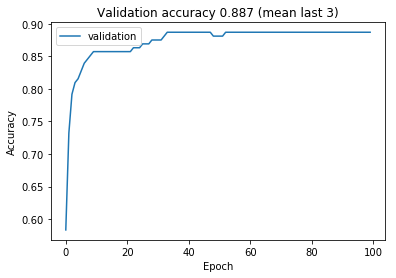

In [39]:
## Plot the validation accuracy curve
#####################################
plt.plot(history.history['val_acc'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
                            np.mean(history.history['val_acc'][-3:])))
plt.legend()
plt.show()

For this first neural network model, we used only one layer and add a $L^2$ regularization term with $\alpha=0.2$. The validation and test accuracy do not change very much if we slightly vary this strength parameter. The validation accuracy is very closed to $0.9$ and the test oscillates around $0.96$. We also specified the learning rate to $0.005$ in the gradient descent algorithm. Replacing this last constant by other values, we remarked that smaller this parameter is, smoother the validation curve is.

## The two layers model

In [40]:
## The architecture
###################
## Create the model 
model = keras.Sequential()
## Add the first layer
model.add(keras.layers.Dense(units=64, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.2),input_dim=1280)) 
## Dropout between the two layers
model.add(keras.layers.Dropout(rate=0.5,seed=0))
## The hidden layer
model.add(keras.layers.Dense(6, activation='softmax',kernel_regularizer=
                             tf.keras.regularizers.l2(0.2)))
## Define loss function, optimizer and metrics to track during training
model.compile(optimizer=optimizers.SGD(lr=0.005),
              loss='sparse_categorical_crossentropy', metrics=['acc'])
## Get summary
print('Model Summary :')
model.summary()

## Run the model
################
history = model.fit(
    x=H_train_rescaled, y=y_train,
    validation_split=0.6, batch_size=32, epochs=100,
    shuffle=True, # Shuffle training samples
    callbacks = [early_stopping],
    verbose=0
)

## Evaluate the test accuracy
#############################
print('Performance on the test set :')
print('')
(test_loss, accuracy_dense2) = model.evaluate(H_test_rescaled, y_test, batch_size=32)
print('Test accuracy two layers : {:.2f}'.format(accuracy_dense2))

Model Summary :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 82,374
Trainable params: 82,374
Non-trainable params: 0
_________________________________________________________________
Performance on the test set :

50/50 [==============================] - 0s 39us/step
Test accuracy two layers : 0.96


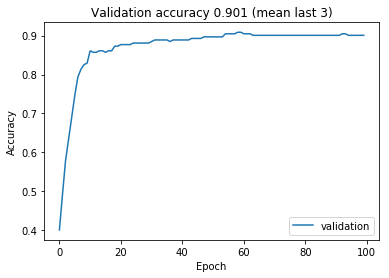

In [41]:
plt.plot(history.history['val_acc'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
                            np.mean(history.history['val_acc'][-3:])))
plt.legend()
plt.show()

In this multilayer neural network, we used two layers with $L^2$ penalities on the two kernels. We remark that adding an hidden layer does not improve the model.

## Convolutional neural network

In [42]:
## Convolutional network
########################
model = keras.Sequential()
sess = backend.get_session()
## The convolutional part
#########################
## The first convolution
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,
                              activation='relu', input_shape=(32, 32, 3)))
## The first max pool layers
model.add(keras.layers.MaxPool2D(pool_size=2,strides=2))
## The second convolution
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                              activation='relu'))
## The second max pool layers
model.add(keras.layers.MaxPool2D(pool_size=2))
## Flatten the result
model.add(keras.layers.Flatten())

## Two layers 
#############
## The hidden layer
model.add(keras.layers.Dense(units=64,kernel_regularizer=tf.keras.regularizers.l2(0.05),
                             activation='relu')) 
model.add(keras.layers.Dropout(rate=0.5,seed=0))
## The output layer
model.add(keras.layers.Dense(units=6, activation='softmax',kernel_regularizer=
                               tf.keras.regularizers.l2(0.05)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

We used principally the same convolutional neural network to the one we saw during the exercises. In the convolutional part, we start with $64$ kernels of size $5\times5$ and strides $2\times 2$, followed by a $2\times 2$ maxpool layer with strides $2\times 2$. We continue again with $3\times 3$ kernels and $1 \times 1$ strides, followed with a maxpool layer of size $2\times 2$ and strides $2\times 2$. 

After `Flatten()` the result, we obtain our high features images that are ready for the dense network. For this final step, we decided to add one hidden layer with $64$ units where we fixed this time the regularization strength to $\alpha=0.05$ as it seems to lead to better performances.

In order to avoid complications, we need to convert the target shape form `(None)` to `(None,6)`.

In [43]:
## Convert targets shape
########################
y_train = pd.get_dummies(pd.DataFrame(y_train).astype('object')).values
y_test = pd.get_dummies(pd.DataFrame(y_test).astype('object')).values

In [44]:
## Run the model
################
## Add optimizer and loss
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', 
              metrics=['acc'])
## Fit the model
history = model.fit(x= X_train,y= y_train,batch_size=32,epochs=100,
            callbacks=[early_stopping],validation_split=0.4,shuffle=True, verbose=0
)

## Evaluate the model on the test set
#####################################
(test_loss, accuracy_CNN) = model.evaluate(X_test, y_test, batch_size=32)
print('Test accuracy CNN : {:.2f}'.format(accuracy_CNN))

50/50 [==============================] - 0s 109us/step
Test accuracy CNN : 0.56


The comparition between the pixel values and its high features format is impressive, namely we pass from $96$% to less than $60$%! On the other hand, this difference is due to the fact that the high level features are extracted from a pre-trained CNN that already optimized million parameters and thus looks much more complex that the one above. Let's try to make this huge difference a bit more concrete.

In [45]:
## Extract the intermediate layer corresponding to Flatten()
###########################################################
extractor = keras.Model(inputs=model.inputs,outputs=model.layers[4].output)
features = extractor(X_train).eval(session=backend.get_session())
features.shape

(419, 256)

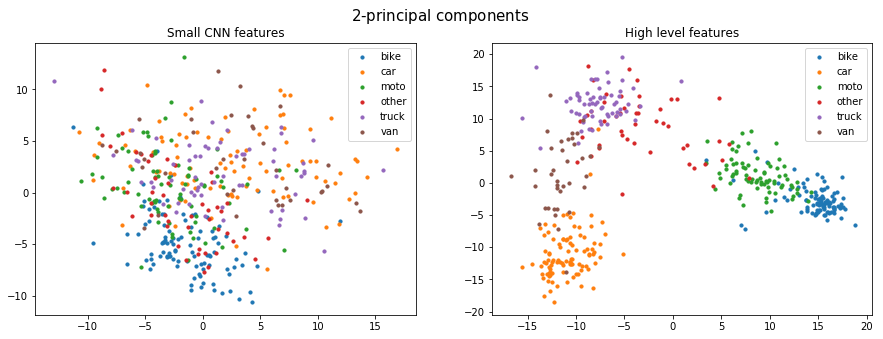

In [46]:
## A scatter plot of the two principal components
#################################################
scaler = StandardScaler()
pca_2 = PCA(n_components=2)
features_rescaled = scaler.fit_transform(features)
features_2d = pca_2.fit_transform(features_rescaled)

fig, axes = plt.subplots(1,2,figsize=(15,5))
for i in range(6):
    idx = (np.argmax(y_train,axis=1) == i)
    axes[0].scatter(features_2d[idx,0],features_2d[idx,1],label=names[i],s=10)
    axes[1].scatter(H_2d[idx,0],H_2d[idx,1],label=names[i],s=10)
    axes[0].legend()
    axes[1].legend()
axes[0].set_title('Small CNN features')
axes[1].set_title('High level features')
plt.suptitle('$2$-principal components',fontsize=15)
plt.show()

We now have a better idea about the difference between the two intermediate classification. The first scatter plot represents the $2$-principal components of the training set obtained after transformation by the convolutional part of the CNN (the part until `Flatten()`). We see that after the first part of the CNN, namely before dense part, the model has difficulty to clearly distinguish the different categories. At least points from the same category are not equidistributed in the whole plane as it was the case for the image pictures. However, this is nothing compared to the powerful intermediate pre-trained model that we used to get our high level features.

# Final comparison

In [47]:
results_df = pd.DataFrame({'model' : ['knn','decision tree','logistic','random forest',
                                     'svm linear','svm rbf','1-layer NN','2-layer NN',
                                     'CNN'],
                    'test_accuracy':[accuracy_knn,accuracy_tree,accuracy_logreg,
                                     accuracy_forest,accuracy_svm_linear,
                                     accuracy_svm_rbf,accuracy_dense1,accuracy_dense2,
                                     accuracy_CNN]})
results_df

,model,test_accuracy
0,knn,0.98
1,decision tree,0.90
2,logistic,0.96
3,random forest,0.92
4,svm linear,0.82
5,svm rbf,0.86
6,1-layer NN,0.96
7,2-layer NN,0.96
8,CNN,0.56


In [48]:
results_df.to_csv('Results.csv',index=False,encoding='utf-8')